In [ ]:
! pip install -U diffusers transformers datasets accelerate bitsandbytes peft
! pip install scikit-image tqdm cleanfid


### Evaluation Matrics


In [ ]:
import random
from PIL import Image
from datasets import load_dataset

dataset = load_dataset("hahminlew/kream-product-blip-captions", split="train")

selected_indices = random.sample(range(len(dataset)), 25)
ground_truth_images = [dataset[i]['image'] for i in selected_indices]


In [ ]:
import os
import random
from PIL import Image
from tqdm import tqdm

# STEP 1: Create directories
os.makedirs("ground_truth", exist_ok=True)
os.makedirs("generated", exist_ok=True)

# STEP 2: Select 25 random indices
selected_indices = random.sample(range(len(dataset)), 5)

# STEP 3: Save ground truth images and extract prompts
ground_truth_images = []
prompts = []

for idx, i in enumerate(selected_indices):
    image = dataset[i]['image']          
    prompt = dataset[i]['text']          
    image.save(f"ground_truth/img_{idx:02d}.png")

    ground_truth_images.append(image)
    prompts.append(prompt)




In [1]:
from diffusers import StableDiffusionPipeline
from diffusers.loaders import AttnProcsLayers
import torch

base_model_id = "CompVis/stable-diffusion-v1-4"


pipe = StableDiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16).to("cuda")
pipe.load_lora_weights("DGM_project/sdxl_lora_finetune", weight_name="pytorch_lora_weights.safetensors")

C:\Users\prite\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


100%|██████████| 80/80 [00:08<00:00,  9.08it/s]


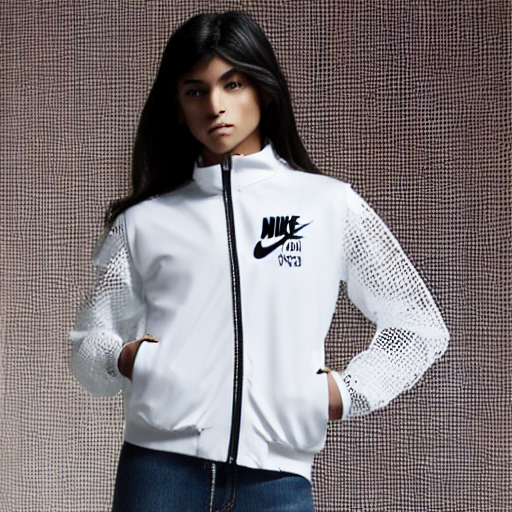

In [33]:
prompt = "A Person wearing a white nike jacket -  with a logo on the chest with clear backgroud and the person is like fashion model and standing in stylish way"

pipe(prompt, num_inference_steps=80, guidance_scale=9).images[0]

In [15]:
from diffusers import StableDiffusionPipeline
import torch

# Load diffusion model (example: Stable Diffusion)
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cuda")

generated_images = []

for idx, prompt in tqdm(enumerate(prompts), total=len(prompts)):
    image = pipe(prompt, num_inference_steps=45, guidance_scale=7.5).images[0]
    image.save(f"generated/img_{idx:02d}.png")
    generated_images.append(image)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [06:18<00:00, 75.77s/it]


In [16]:
print(prompts)

['top, Supreme American Psycho Sweater Black - 23FW, a photography of a black sweatshirt with a picture of a man wearing a tie', 'top,  Undermycar Mu.09 Anti Fxxking Logo Play Oversized Hoodie Olive, a photography of a black hoodie with a tag on it', 'bottom, Stone Island Shadow Project 30328 Strertch Cotton Nylon Gabardine Ventilation Trousers Black - 23SS, a photography of a black pants with zippers and a white background', 'outer,  The North Face Nuptse Short Jacket Purple, a photography of the north face purple and black nupts jacket', 'top, Lacoste Neo Heritage Net Print T-Shirt Green, a photography of a green t - shirt with a crocodile on the front']


In [19]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Paths
gen_path = "generated"
gt_path = "ground_truth"

# Metrics
psnr_scores = []
ssim_scores = []

# Compute PSNR & SSIM
for i in tqdm(range(len(prompts))):
    gen_img = Image.open(os.path.join(gen_path, f"img_{i:02d}.png")).convert("RGB")
    gt_img = Image.open(os.path.join(gt_path, f"img_{i:02d}.png")).convert("RGB")

    gen_np = np.array(gen_img.resize((256, 256))) / 255.0
    gt_np = np.array(gt_img.resize((256, 256))) / 255.0

    psnr_scores.append(psnr(gt_np, gen_np, data_range=1.0))
    ssim_scores.append(ssim(gt_np, gen_np, channel_axis=-1, data_range=1.0))


print(f"Average PSNR: {np.mean(psnr_scores):.4f}")
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")


100%|██████████| 5/5 [00:00<00:00, 19.45it/s]

Average PSNR: 6.9765
Average SSIM: 0.3609
